# Test Major Algorithms

Regret analysis

In [1]:
%matplotlib inline
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import math
import numpy as np
import pandas as pd
import copy
import sys
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
plt.rcParams['font.size'] = 13
plt.style.use("ggplot")
mpl.rcParams['font.family'] = "Osaka"

## Common framework

Consider the case that there are 3 arms: $A = \{a_1, a_2, a_3\}$. At each round $t = 1, 2, \ldots, T$, a player chooses an arm $a_t \in A$ and gets a random reward $r_t$. We assume the reward is an i.i.d. sample from the bernouli distribution $Ber(p_a)$, where 

$$
p_a = \begin{cases}
0.25 & \text{if $a = a_1$} \\
0.5 & \text{if $a = a_2$} \\
0.75 & \text{if $a = a_3$}
\end{cases}
$$

A player initially does not know the true value of $p_a$ but does know the average performance among the all arms: $\mu = 0.5$.

In [2]:
class MAB(object):
    def __init__(self, n_arms, payoff_dists, opt_arm_expected_payoff, rs=None):
        self.n_arms = n_arms
        self.payoff_dists = payoff_dists
        self.opt_payoff = opt_arm_expected_payoff
        if rs is None:
            self.seed = np.random.randint(2**32 - 1)
            self.rs = np.random.RandomState(self.seed)
        else:
            self.rs = rs

    def pull_arm(self, arm, n=1):
        if not isinstance(arm, int) or arm < 0 or self.n_arms <= arm:
            raise ValueError(arm)
        
        payoff = np.sum(self.payoff_dists[arm].rvs(n, random_state=self.rs))
        regret = self.opt_payoff * n - payoff
        return payoff, regret
    

In [3]:
n_arms = 3
dists = [st.bernoulli(0.25*(i+1)) for i in range(n_arms)]
opt_arm_expected_payoff = max([d.mean() for d in dists]) # = 0.75
mab = MAB(n_arms, dists, opt_arm_expected_payoff)

for i in range(10):
    arm = i % 3
    p, r = mab.pull_arm(arm)
    print("t={0:d}, arm={1:d}, reward={2: .3f}, regret={3: .3f}".format(i, arm, p, r))

t=0, arm=0, reward= 1.000, regret=-0.250
t=1, arm=1, reward= 0.000, regret= 0.750
t=2, arm=2, reward= 1.000, regret=-0.250
t=3, arm=0, reward= 0.000, regret= 0.750
t=4, arm=1, reward= 0.000, regret= 0.750
t=5, arm=2, reward= 1.000, regret=-0.250
t=6, arm=0, reward= 1.000, regret=-0.250
t=7, arm=1, reward= 1.000, regret=-0.250
t=8, arm=2, reward= 1.000, regret=-0.250
t=9, arm=0, reward= 1.000, regret=-0.250


## 0. Preliminaries

In [4]:
seed = 1234

In [5]:
def kl_ber(p, q, eps=1e-5):
    # q=0 or 1 case
    if q < eps or q > 1 - eps:
        return float("inf")
    
    # p=0 or 1 case
    if p < eps:
        return (1-p) * np.log((1-p)/(1-q)) 
    elif p > 1 - eps:
        return p * np.log(p/q)
    
    return p * np.log(p/q) + (1-p) * np.log((1-p)/(1-q)) 

In [6]:
class Policy(object):
    def __init__(self, mab, ts_length, rs=None):
        self.mab = mab
        self.ts_length = ts_length
        
        if rs is None:
            self.seed = np.random.randint(2**32 - 1)
            self.rs = np.random.RandomState(self.seed)
        else:
            self.rs = rs
        
        self.n_arms = mab.n_arms
        self.t = 0
        self.n_pull = np.zeros(self.n_arms, dtype=int)
        self.sum_payoffs = np.zeros(self.n_arms, dtype=float)
        self.sum_regrets = np.zeros(self.n_arms, dtype=float)
        
    def proceed(self):
        pass
    
    def get_average_score(self):
        average_payoff = np.sum(self.sum_payoffs) / self.t
        average_regret = np.sum(self.sum_regrets) / self.t
        return average_payoff, average_regret
        

## 1. Explore-First

In [7]:
class ExploreFirst(Policy):
    """
    Implement the Explore-First policy.
    
    * ts_explore: the number of rounds which this algorithm uses for an exploration of EACH arm
    """
    def __init__(self, mab, ts_length, ts_explore):
        super().__init__(mab, ts_length)
        
        self.ts_explore = ts_explore
        self.total_ts_explore = ts_explore * self.n_arms
        if self.total_ts_explore >= self.ts_length:
            raise ValueError(
                "Explore rounds (times n_arms) should be less than or equal to `ts_length`")
        
        self.opt_arm = None
        
    def proceed(self):
        if self.t >= self.ts_length:
            raise ValueError("current time exceeds `ts_length`")
            
        if self.t == self.total_ts_explore:
            mean_payoff = self.sum_payoffs / self.n_pull
            self.opt_arm = int(np.argmax(mean_payoff))
            
        if self.t < self.total_ts_explore:
            arm = int(self.t // self.ts_explore)
        else:
            arm = int(self.opt_arm)
        
        p, r = self.mab.pull_arm(arm)
        self.n_pull[arm] += 1
        self.sum_payoffs[arm] += p
        self.sum_regrets[arm] += r
        self.t += 1
   

In [8]:
rs = np.random.RandomState(seed)
mab = MAB(n_arms, dists, opt_arm_expected_payoff, rs=rs)
ts_length = 50
ts_explore = 5

for i in range(20):
    efp = ExploreFirst(mab, ts_length, ts_explore)

    for t in range(ts_length):
        efp.proceed()

    p, r = efp.get_average_score()
    
    print(
        "i={:02d}, n_pull={}, sum_payoffs: {}, sum_regrets: {}, "
        "average payoff: {:.3f}, average regret: {:.3f}"
        .format(i, efp.n_pull, efp.sum_payoffs, efp.sum_regrets, p, r)
        )

i=00, n_pull=[ 5  5 40], sum_payoffs: [  2.   3.  32.], sum_regrets: [ 1.75  0.75 -2.  ], average payoff: 0.740, average regret: 0.010
i=01, n_pull=[ 5 40  5], sum_payoffs: [  0.  24.   5.], sum_regrets: [ 3.75  6.   -1.25], average payoff: 0.580, average regret: 0.170
i=02, n_pull=[40  5  5], sum_payoffs: [ 10.   2.   3.], sum_regrets: [ 20.     1.75   0.75], average payoff: 0.300, average regret: 0.450
i=03, n_pull=[ 5 40  5], sum_payoffs: [  2.  24.   2.], sum_regrets: [ 1.75  6.    1.75], average payoff: 0.560, average regret: 0.190
i=04, n_pull=[ 5  5 40], sum_payoffs: [  3.   1.  31.], sum_regrets: [ 0.75  2.75 -1.  ], average payoff: 0.700, average regret: 0.050
i=05, n_pull=[ 5 40  5], sum_payoffs: [  1.  26.   3.], sum_regrets: [ 2.75  4.    0.75], average payoff: 0.600, average regret: 0.150
i=06, n_pull=[ 5  5 40], sum_payoffs: [  1.   2.  27.], sum_regrets: [ 2.75  1.75  3.  ], average payoff: 0.600, average regret: 0.150
i=07, n_pull=[ 5 40  5], sum_payoffs: [  1.  22.   4

Evalueate average regret

In [9]:
ts_length = 1000
c = 1/16
epsilon = 2 * n_arms * np.log(ts_length) / (c * ts_length)
ts_explore = int(epsilon * ts_length // n_arms)
epsilon, ts_explore

(0.66314450678228509, 221)

Compare simulated average regret and theoretical uppder bound of regret

In [10]:
size = 100
regrets = np.zeros(size)
rs = np.random.RandomState(seed)
mab = MAB(n_arms, dists, opt_arm_expected_payoff, rs=rs)

for i in range(size):
    efp = ExploreFirst(mab, ts_length, ts_explore)
    
    for t in range(ts_length):
        efp.proceed()

    p, r = efp.get_average_score()
    regrets[i] = r

regrets *= ts_length
sum_regret = np.mean(regrets)
upper_bound_regret = (1/2 + 1/4) * (2 * np.log(ts_length) / c + 1)
print(sum_regret, upper_bound_regret)

164.26 166.536126696


Simulated mean: 166.42, Upper bound: 166.536

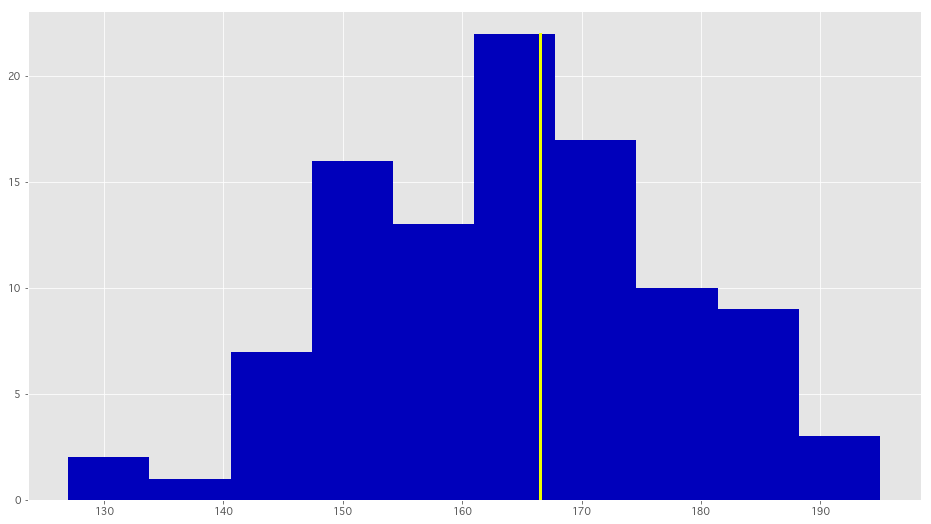

In [11]:
fig = plt.figure(figsize=(16, 9))
plt.hist(regrets, color="#0000BB")
plt.plot([upper_bound_regret, upper_bound_regret], [0, 22], color="#EEFF00", linewidth="3")
plt.show()

## 2. Epsilon-Greedy

In [12]:
class EpsilonGreedy(Policy):
    """
    Implement the Epsilon-Greedy policy.
    
    * ts_explore: the number of rounds which this algorithm uses for an exploration of EACH arm
    """
    def __init__(self, mab, ts_length, ts_explore):
        super().__init__(mab, ts_length)
        
        self.ts_explore = ts_explore
        self.total_ts_explore = ts_explore * self.n_arms
        if self.total_ts_explore >= self.ts_length:
            raise ValueError(
                "Explore rounds (times n_arms) should be less than or equal to `ts_length`")
        
        self.opt_arm = None
        
    def proceed(self):
        if self.t >= self.ts_length:
            raise ValueError("current time exceeds `ts_length`")
            
        if self.t < self.total_ts_explore:
            arm = int(self.t // self.ts_explore)
        else:
            mean_payoff = self.sum_payoffs / self.n_pull
            arm = int(np.argmax(mean_payoff))
        
        p, r = self.mab.pull_arm(arm)
        self.n_pull[arm] += 1
        self.sum_payoffs[arm] += p
        self.sum_regrets[arm] += r
        self.t += 1
   

Compute simulated average regret

In [13]:
size = 100
regrets = np.zeros(size)
rs = np.random.RandomState(seed)
mab = MAB(n_arms, dists, opt_arm_expected_payoff, rs=rs)

for i in range(size):
    eps = EpsilonGreedy(mab, ts_length, ts_explore)
    
    for t in range(ts_length):
        eps.proceed()

    p, r = eps.get_average_score()
    regrets[i] = r

regrets *= ts_length
sum_regret = np.mean(regrets)
print(sum_regret)

164.26


(In this example) simulate average regret is same as that of Explore-First case

## 3. UCB1

In [14]:
class UCB1(Policy):
    """
    Implement the UCB1 policy.
    
    """
    def __init__(self, mab, ts_length):
        super().__init__(mab, ts_length)
        
    def proceed(self):
        # choose an arm
        if self.t < self.n_arms:
            arm = self.t
        else:
            values = [
                self.get_score(self.t, self.sum_payoffs[a], self.n_pull[a]) for a in range(self.n_arms)]
            arm = int(np.argmax(values))
        
        p, r = mab.pull_arm(arm)
        self.n_pull[arm] += 1
        self.sum_payoffs[arm] += p
        self.sum_regrets[arm] += r
        self.t += 1
    
    @staticmethod
    def get_score(t, total, size):
        return total/size + np.sqrt(np.log(t) / (2 * size))

Count how many times each arm is pulled

In [15]:
ts_length = 300
rs = np.random.RandomState(seed)
mab = MAB(n_arms, dists, opt_arm_expected_payoff, rs=rs)

ucb1 = UCB1(mab, ts_length)
for t in range(ts_length):
    ucb1.proceed()
    p, r = ucb1.get_average_score()
    if t % 20 == 19:
        print(
            "t={:02d}, n_pull={}, sum_payoffs: {}, sum_regrets: {}"
            .format(ucb1.t, ucb1.n_pull, ucb1.sum_payoffs, ucb1.sum_regrets)
            )

t=20, n_pull=[ 5 11  4], sum_payoffs: [ 2.  7.  1.], sum_regrets: [ 1.75  1.25  2.  ]
t=40, n_pull=[ 7 22 11], sum_payoffs: [  2.  11.   5.], sum_regrets: [ 3.25  5.5   3.25]
t=60, n_pull=[ 7 22 31], sum_payoffs: [  2.  11.  20.], sum_regrets: [ 3.25  5.5   3.25]
t=80, n_pull=[ 7 22 51], sum_payoffs: [  2.  11.  38.], sum_regrets: [ 3.25  5.5   0.25]
t=100, n_pull=[ 7 22 71], sum_payoffs: [  2.  11.  54.], sum_regrets: [ 3.25  5.5  -0.75]
t=120, n_pull=[ 7 22 91], sum_payoffs: [  2.  11.  67.], sum_regrets: [ 3.25  5.5   1.25]
t=140, n_pull=[  7  22 111], sum_payoffs: [  2.  11.  83.], sum_regrets: [ 3.25  5.5   0.25]
t=160, n_pull=[ 11  22 127], sum_payoffs: [  4.  11.  94.], sum_regrets: [ 4.25  5.5   1.25]
t=180, n_pull=[ 12  22 146], sum_payoffs: [   4.   11.  104.], sum_regrets: [ 5.   5.5  5.5]
t=200, n_pull=[ 12  24 164], sum_payoffs: [   4.   12.  119.], sum_regrets: [ 5.  6.  4.]
t=220, n_pull=[ 12  24 184], sum_payoffs: [   4.   12.  134.], sum_regrets: [ 5.  6.  4.]
t=240, n

For consistency, non-optimal arms should be pulled at least $O(\log t)$ times by $t$ period

In [16]:
np.log(300)

5.7037824746562009

Compare simulated average regret / theoretical uppder bound of regret

In [17]:
ts_length = 1000
size = 100
regrets = np.zeros(size)
rs = np.random.RandomState(seed)
mab = MAB(n_arms, dists, opt_arm_expected_payoff, rs=rs)

for i in range(size):
    ucb1 = UCB1(mab, ts_length)
    
    for t in range(ts_length):
        ucb1.proceed()

    p, r = ucb1.get_average_score()
    regrets[i] = r

regrets *= ts_length
sum_regret = np.mean(regrets)


print(sum_regret)

14.79


In [18]:
upper_bound_regret = np.log(ts_length) / 2 / (1/2) + np.log(ts_length) / 2 / (1/4)
print(sum_regret, upper_bound_regret)

14.79 20.7232658369


## 4. DMED

In [19]:
class DMED(Policy):
    """
    Implement the DMED policy.
    
    """
    def __init__(self, mab, ts_length):
        super().__init__(mab, ts_length)

        self.current_loop_arms = np.ones(self.n_arms, dtype=bool)
        self.next_loop_arms = np.zeros(self.n_arms, dtype=bool)
        
    def proceed(self):
        if self.t >= self.ts_length:
            raise ValueError("current time exceeds `ts_length`")
            
        # choose an arm
        if self.t < self.n_arms:
            arm = self.t
        else:
            if np.sum(self.current_loop_arms) == 0:
                self.current_loop_arms, self.next_loop_arms \
                    = self.next_loop_arms, self.current_loop_arms
            
            for a in range(self.n_arms):
                if self.current_loop_arms[a]:
                    self.current_loop_arms[a] = False
                    arm = a
                    break
            else:
                raise ValueError(self.current_loop_arms, self.next_loop_arms)
            
        p, r = mab.pull_arm(arm)
        self.n_pull[arm] += 1
        self.sum_payoffs[arm] += p
        self.sum_regrets[arm] += r
        
        # update arms for next loop
        if self.n_arms <= self.t:
            aves = self.sum_payoffs / self.n_pull
            opt_arm = np.argmax(aves)
            highest_ave = aves[opt_arm]
            
            score_criterion = np.log(self.t)
            for a in range(self.n_arms):
                # handling kl divergence = infinity case
                if a == opt_arm:
                    self.next_loop_arms[a] = True
                else:
                    score = self.n_pull[a] * kl_ber(aves[a], highest_ave)
                    if score <= score_criterion:
                        self.next_loop_arms[a] = True
            
        self.t += 1
        

For consistency, non-optimal arms should be pulled at least $O(\log t)$ times by $t$ period

In [20]:
ts_length = 300
rs = np.random.RandomState(seed)
mab = MAB(n_arms, dists, opt_arm_expected_payoff, rs=rs)

dmed = DMED(mab, ts_length)
for t in range(ts_length):
    dmed.proceed()
    p, r = dmed.get_average_score()
    if t % 20 == 19:
        print(
            "t={:02d}, n_pull={}, sum_payoffs: {}, sum_regrets: {}"
            .format(dmed.t, dmed.n_pull, dmed.sum_payoffs, dmed.sum_regrets)
            )

t=20, n_pull=[6 7 7], sum_payoffs: [ 2.  6.  5.], sum_regrets: [ 2.5  -0.75  0.25]
t=40, n_pull=[10 15 15], sum_payoffs: [ 2.  9.  8.], sum_regrets: [ 5.5   2.25  3.25]
t=60, n_pull=[12 24 24], sum_payoffs: [  2.  14.  14.], sum_regrets: [ 7.  4.  4.]
t=80, n_pull=[12 34 34], sum_payoffs: [  2.  15.  22.], sum_regrets: [  7.   10.5   3.5]
t=100, n_pull=[12 44 44], sum_payoffs: [  2.  21.  29.], sum_regrets: [  7.  12.   4.]
t=120, n_pull=[12 54 54], sum_payoffs: [  2.  26.  37.], sum_regrets: [  7.   14.5   3.5]
t=140, n_pull=[12 58 70], sum_payoffs: [  2.  28.  50.], sum_regrets: [  7.   15.5   2.5]
t=160, n_pull=[12 58 90], sum_payoffs: [  2.  28.  63.], sum_regrets: [  7.   15.5   4.5]
t=180, n_pull=[ 12  64 104], sum_payoffs: [  2.  31.  70.], sum_regrets: [  7.  17.   8.]
t=200, n_pull=[ 12  67 121], sum_payoffs: [  2.  32.  84.], sum_regrets: [  7.    18.25   6.75]
t=220, n_pull=[ 12  67 141], sum_payoffs: [  2.  32.  99.], sum_regrets: [  7.    18.25   6.75]
t=240, n_pull=[ 12  

In [21]:
np.log(300)

5.7037824746562009

Compare simulated average regret / theoretical uppder bound of regret

In [22]:
ts_length = 1000
size = 100
regrets = np.zeros(size)
rs = np.random.RandomState(seed)
mab = MAB(n_arms, dists, opt_arm_expected_payoff, rs=rs)

for i in range(size):
    dmed = DMED(mab, ts_length)
    
    for t in range(ts_length):
        dmed.proceed()

    p, r = ucb1.get_average_score()
    regrets[i] = r

regrets *= ts_length
sum_regret = np.mean(regrets)


print(sum_regret)

26.0


In [23]:
upper_bound_regret = np.log(ts_length) * (1/4 / kl_ber(1/4, 3/4) + 1/2 / kl_ber(1/2, 3/4))
print(sum_regret, upper_bound_regret)

26.0 27.1556232504


In [24]:
print(kl_ber(1/4, 3/4), kl_ber(1/2, 3/4))

0.549306144334 0.143841036226


##  5. Thompson Sampling

prior: $Beta(1, 1)$

In [25]:
class ThompsonSampling(Policy):
    """
    Implement the Thompson-Sampling policy.
    
    * priors: prior distributions of the rewards of arms
    * update_func: function that updates prior distributions
    """
    def __init__(self, mab, ts_length, priors, update_func):
        super().__init__(mab, ts_length)
        
        if len(priors) != mab.n_arms:
            raise ValueError
        
        self.priors = priors
        self.update_func = update_func
        
    def update_priors(self, arm, payoff):
        self.priors = self.update_func(self.priors, arm, payoff)
        
    def proceed(self):
        if self.t >= self.ts_length:
            raise ValueError("current time exceeds `ts_length`")
            
        # choose an arm
        values = [priors[a].rvs(random_state=self.rs) for a in range(self.n_arms)]
        arm = int(np.argmax(values))
        
        p, r = mab.pull_arm(arm)
        self.n_pull[arm] += 1
        self.sum_payoffs[arm] += p
        self.sum_regrets[arm] += r
        self.update_priors(arm, p)
        self.t += 1
        

For consistency, non-optimal arms should be pulled at least $O(\log t)$ times by $t$ period

In [26]:
ts_length = 300
priors = [st.beta(1, 1) for i in range(n_arms)]
rs = np.random.RandomState(seed)
mab = MAB(n_arms, dists, opt_arm_expected_payoff, rs=rs)

def update_priors(priors, arm, payoff):
    if payoff == 1:
        a = priors[arm].args[0] + 1
        b = priors[arm].args[1]
    elif payoff == 0:
        a = priors[arm].args[0]
        b = priors[arm].args[1] + 1
    else:
        raise ValueError
    
    priors[arm].args = (a, b)
    return priors

thompson = ThompsonSampling(mab, ts_length, priors, update_priors)
for t in range(ts_length):
    thompson.proceed()
    p, r = thompson.get_average_score()
    if t % 20 == 19:
        beta_exp = np.array([thompson.priors[a].mean() for a in range(thompson.n_arms)])
        print(
            "t={:02d}, n_pull={}, sum_payoffs: {}, sum_regrets: {}, beta_expectation: {}"
            .format(thompson.t, thompson.n_pull, thompson.sum_payoffs, thompson.sum_regrets, beta_exp)
            )

t=20, n_pull=[ 3 13  4], sum_payoffs: [ 0.  8.  1.], sum_regrets: [ 2.25  1.75  2.  ], beta_expectation: [ 0.2    0.6    0.333]
t=40, n_pull=[ 4 28  8], sum_payoffs: [  0.  16.   3.], sum_regrets: [ 3.  5.  3.], beta_expectation: [ 0.167  0.567  0.4  ]
t=60, n_pull=[ 4 47  9], sum_payoffs: [  0.  28.   3.], sum_regrets: [ 3.    7.25  3.75], beta_expectation: [ 0.167  0.592  0.364]
t=80, n_pull=[ 4 64 12], sum_payoffs: [  0.  33.   6.], sum_regrets: [  3.  15.   3.], beta_expectation: [ 0.167  0.515  0.5  ]
t=100, n_pull=[ 4 71 25], sum_payoffs: [  0.  39.  18.], sum_regrets: [  3.    14.25   0.75], beta_expectation: [ 0.167  0.548  0.704]
t=120, n_pull=[ 4 71 45], sum_payoffs: [  0.  39.  31.], sum_regrets: [  3.    14.25   2.75], beta_expectation: [ 0.167  0.548  0.681]
t=140, n_pull=[ 4 73 63], sum_payoffs: [  0.  41.  46.], sum_regrets: [  3.    13.75   1.25], beta_expectation: [ 0.167  0.56   0.723]
t=160, n_pull=[ 4 73 83], sum_payoffs: [  0.  41.  59.], sum_regrets: [  3.    13.7

In [27]:
ts_length = 1000
size = 100
regrets = np.zeros(size)
rs = np.random.RandomState(seed)
mab = MAB(n_arms, dists, opt_arm_expected_payoff, rs=rs)

for i in range(size):
    thompson = ThompsonSampling(mab, ts_length, priors, update_priors)
    
    for t in range(ts_length):
        thompson.proceed()

    p, r = thompson.get_average_score()
    regrets[i] = r

regrets *= ts_length
sum_regret = np.mean(regrets)

Compare simulated average regret / theoretical uppder bound of regret

In [28]:
upper_bound_regret = np.log(ts_length) * (1/4 / kl_ber(1/4, 3/4) + 1/2 / kl_ber(1/2, 3/4))
print(sum_regret, upper_bound_regret)

0.49 27.1556232504
